In [1]:
import albumentations as A
import numpy as np
import os
import random
import sys

import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torch import nn, Tensor

from functools import partial
from omegaconf import DictConfig
from tqdm.notebook import tqdm
from typing import Any, Callable, Dict, Iterable, List, Tuple

In [2]:
import cv2
import PIL
import kornia

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
BASE_DIR = '/home/dmitry/projects/dfdc'
SRC_DIR = os.path.join(BASE_DIR, 'src')
HDF5_DIR = '/home/dmitry/projects/dfdc/data/dfdc-crops'
IMG_DIR = '/media/dmitry/other/dfdc-crops/webp_lossy'

In [5]:
sys.path.insert(0, SRC_DIR)

In [6]:
from dataset import HDF5Dataset, ImagesDataset, FrameSampler, BalancedSampler
from dataset.transforms import image_grad

In [7]:
sys.path.insert(0, './nb_utils')
from visualise import show_images

In [8]:
from torch.utils.data import DataLoader

In [9]:
sys.path.insert(0, os.path.join(SRC_DIR, 'train.py'))

In [10]:
def create_loader(conf: Dict, transforms: Iterable[Callable], transforms_3d: Any,
                  dirs: Iterable[str]) -> DataLoader:
    print(conf)
    num_frames = conf['frames']
    
    sampler = FrameSampler(num_frames, 
                           real_fake_ratio=conf['real_fake_ratio'],
                           p_sparse=conf['p_sparse'])
    
    ds = HDF5Dataset(HDF5_DIR,
                     frames=num_frames,
                     sampler=sampler,
                     min_img_size=conf['min_img_size'],
                     transforms=transforms,
                     transforms_3d=transforms_3d,
                     sub_dirs=dirs)
    print("Num samples: {}".format(len(ds)))

#     sampler = BalancedSampler(ds, 
#         num_samples=conf['num_samples'],
#         rank=conf['rank'],
#         num_replicas=conf['num_replicas'])
#     if 'epoch' in conf:
#         sampler.set_epoch(conf['epoch'])
    return DataLoader(ds, 
        sampler=None, 
        batch_size=conf['batch_size'],
        drop_last=True,
        num_workers=conf.get('loader.workers', 0))

In [11]:
from dataset.transforms import *

In [31]:
dirs = ['dfdc_train_part_%d' % i for i in range(50)]
dirs = ['dfdc_train_part_%d' % i for i in [19,32,41,43]]

transforms = T.Compose([
    T.ToTensor(),
    UpscaleIfBelow(86),
    PadIfNeeded(256, mode='reflect', normalize=False),
    CropCenter(256),
#     SpatialGradFilter(order=3),
#     T.Normalize(
#         mean=[7.99074656e-10, 9.42090607e-10, 6.85161949e-10],
#         std=[0.03253524, 0.03236544, 0.03264875]
#     )
])

transforms_3d = None
# transforms_3d = T.Compose([
#     # kornia.augmentation.RandomHorizontalFlip(p=0.5)
#     RandomHorizontalFlipTensor(p=0.5),
# ])

In [32]:
conf = dict(
    real_fake_ratio=100/30, 
    p_sparse=1.0, 
    img_size=256,
    min_img_size=38,
    frames=10,
    batch_size=16,
    rank=None,
    num_replicas=None,
    num_samples=300_000,
    epoch=1
)

dl = create_loader(conf, transforms, transforms_3d, dirs)

{'real_fake_ratio': 3.3333333333333335, 'p_sparse': 1.0, 'img_size': 256, 'min_img_size': 38, 'frames': 10, 'batch_size': 16, 'rank': None, 'num_replicas': None, 'num_samples': 300000, 'epoch': 1}
Num samples: 9846


In [33]:
data_iter = iter(dl)

In [15]:
mean = np.array([0.0] * 3)
std = np.array([0.0] * 3)

for i in tqdm(range(len(dl))):
    x, y = next(data_iter)
    m, s = x.mean((0, 2, 3, 4)), x.std((0, 2, 3, 4))
    for c in range(3):
        mean[c] += m[c].item()
        std[c] += s[c].item()

In [16]:
mean/(i+1), std/(i+1)

(array([-2.12102930e-09, -1.77498737e-09, -1.73837650e-09]),
 array([0.05533417, 0.05484635, 0.05519658]))

In [17]:
# x.shape, x.device

In [18]:
# 100, 256px, n=3, cuda - 1:45s
# 100, 256px, n=3, cpu - 1:43s

In [19]:
# images = x.permute(0, 2, 3, 4, 1)[:, 0].cpu().numpy()

In [20]:
# images.clip(min=-1, max=1).min()

In [21]:
# images.max(), images.min()

In [22]:
# images = x.flip(-1).permute(0, 2, 3, 4, 1)[0].cpu().numpy()
# show_images(images, cols=len(images)//4)

In [23]:
# images = x.permute(0, 2, 3, 4, 1)[:, 0].cpu().numpy()
# show_images(images, cols=len(images)//4)

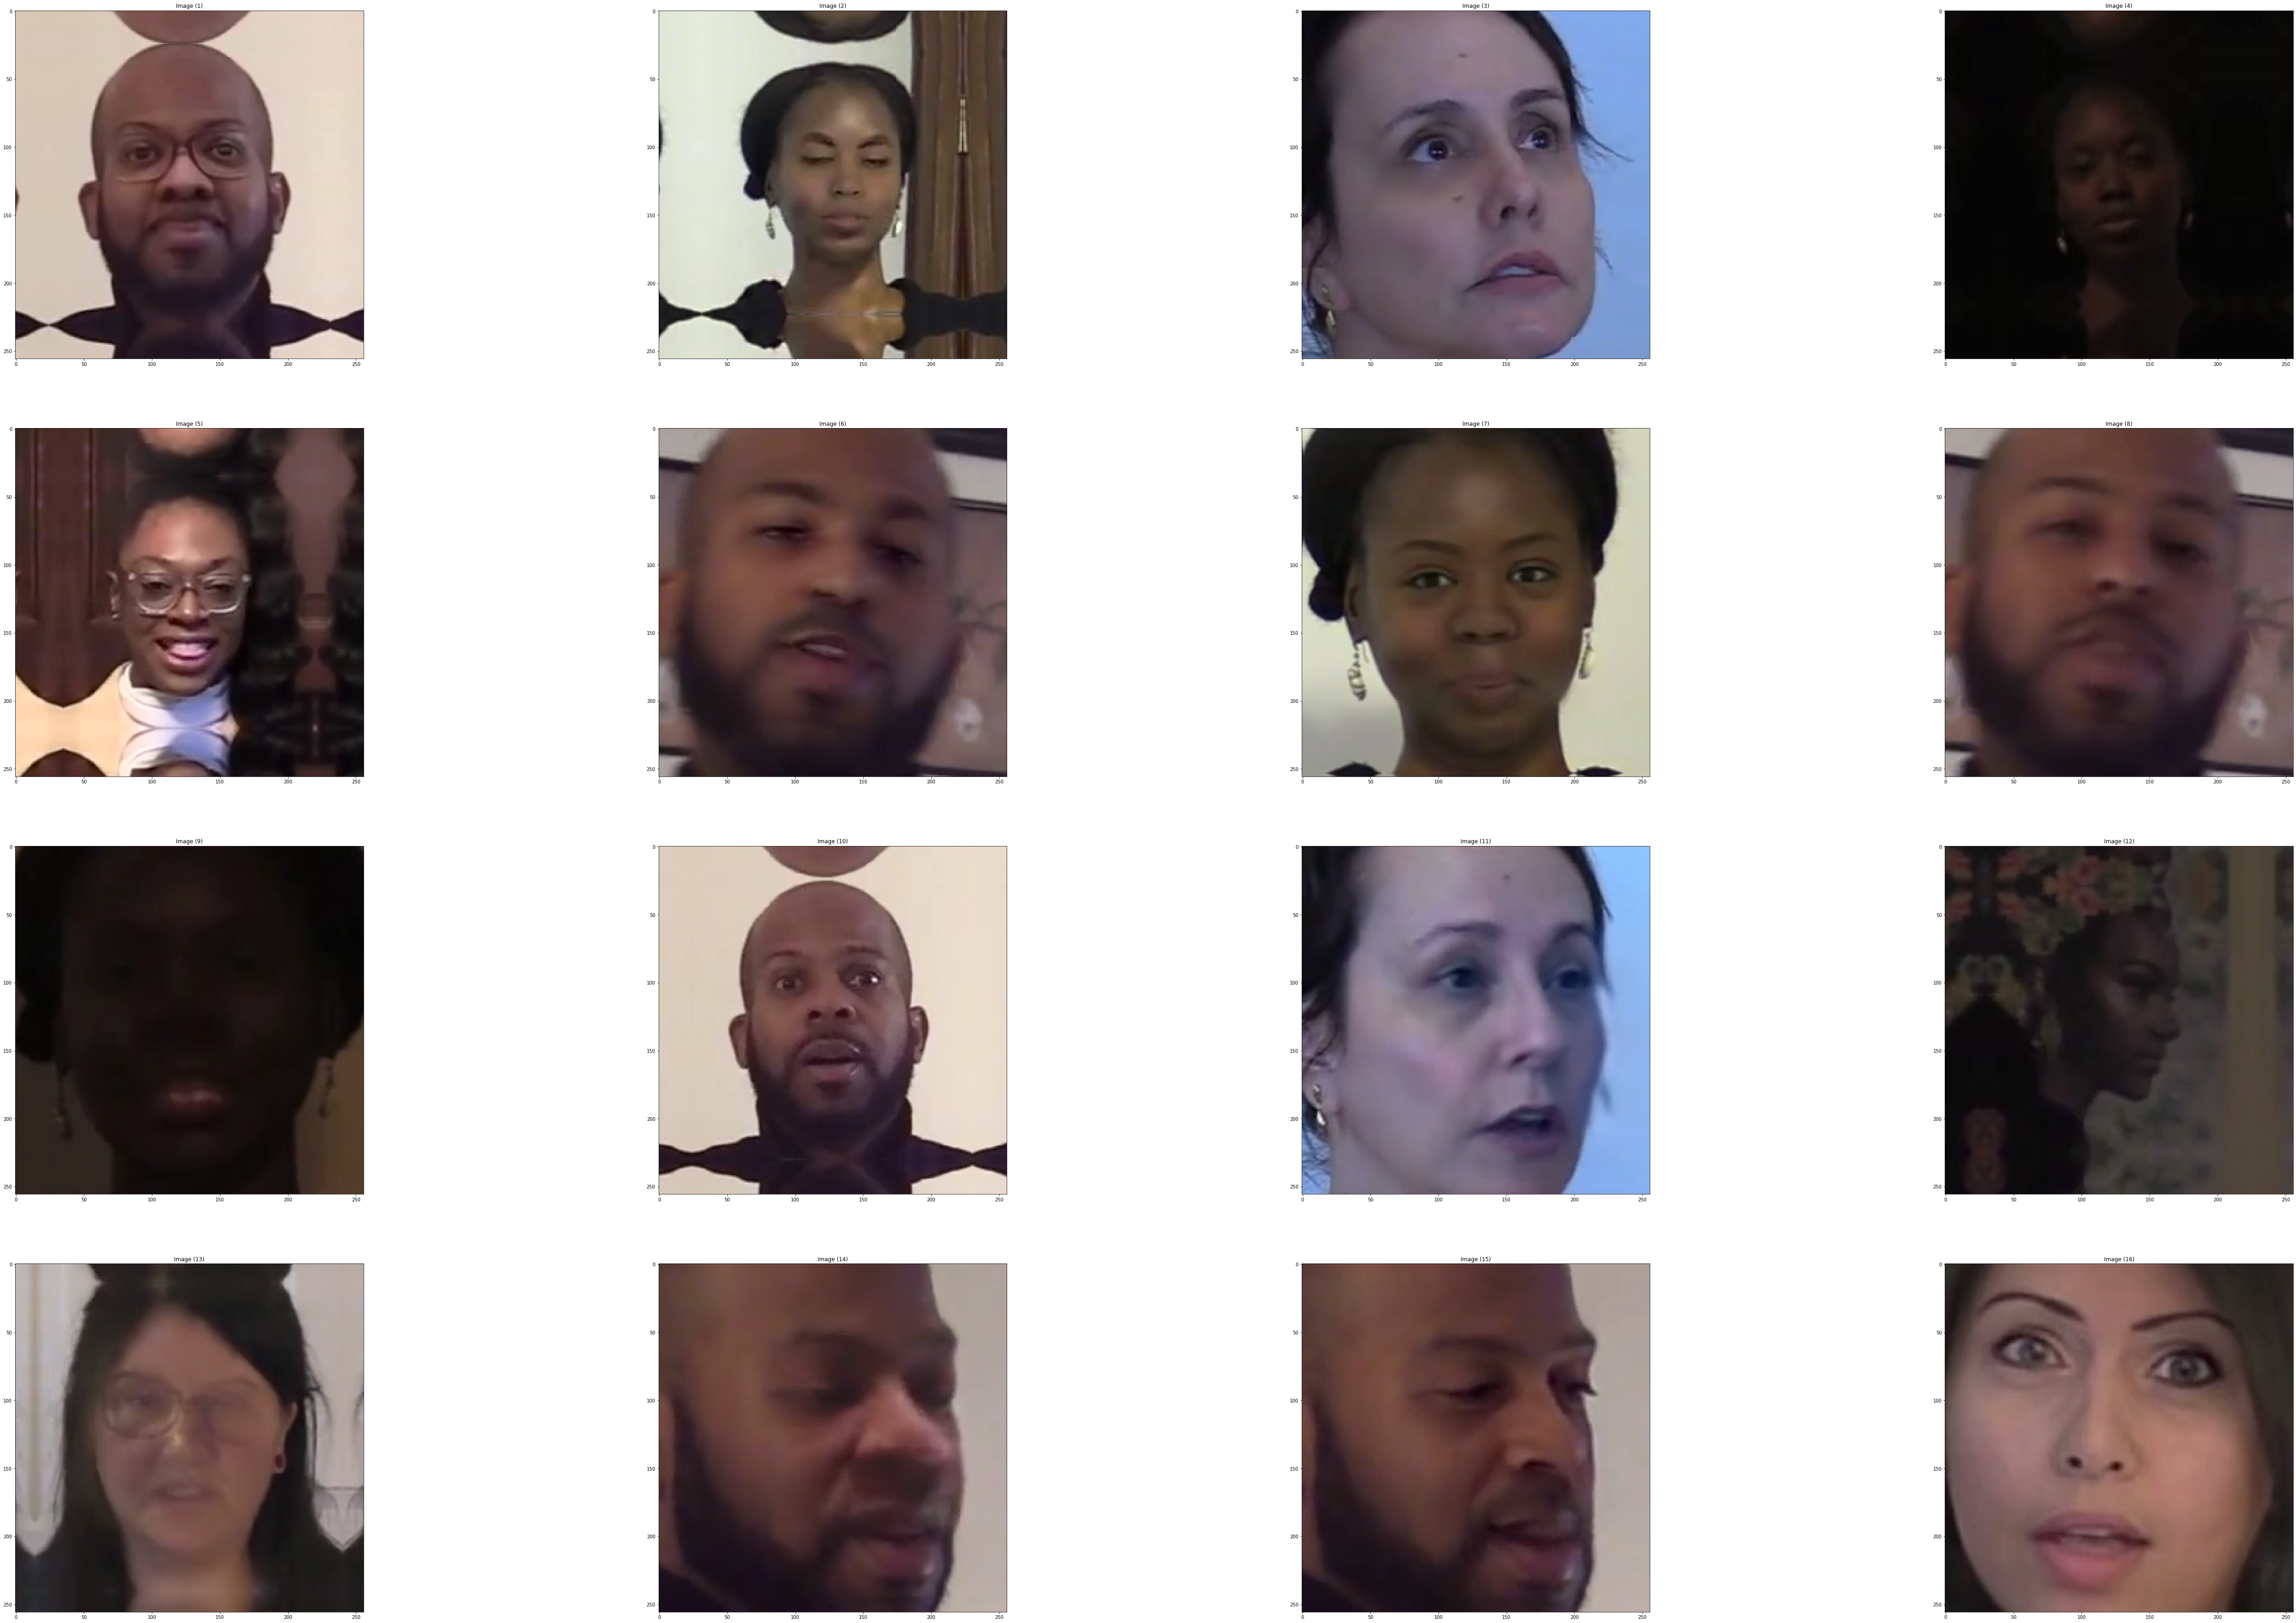

In [45]:
x, y = next(data_iter)
images = x.permute(0, 2, 3, 4, 1)[:,0].cpu().numpy() # * (i+1) / std
show_images(images, cols=len(images)//4)

In [ ]:
images = x.permute(0, 2, 3, 4, 1)[1].cpu().numpy()
show_images(images, cols=len(images)//4)

In [ ]:
images = x.permute(0, 2, 3, 4, 1)[1].cpu().numpy()
show_images(images, cols=len(images)//4)